In [1]:
from FeedForwardNN import Feedforward
from Toy_Datasets import two_clusters_gaussian
from Neural_Network import NLM
import autograd.numpy as np
from autograd import grad
import matplotlib.pyplot as plt
from autograd.misc.optimizers import adam
from Bayesian_pdf import get_log_prior, get_log_likelihood
from Hamiltonian_MC import hmc

In [2]:
def two_clusters_gaussian(params, n_samples, test_points=None):
    """
    :param params: should be a list of length K, K being the number of classes you wish to create
    for every class 0 <= k <=K-1, params[k] should be a dictionnary containing two keys: mean and covariance_matrix.
    The shapes expected for mean are D and covariance_matrix are D*D where D is the number of features for every
    datapoint.
    :param n_samples: number of samples you wish to create for every cluster
    :param test_points: OOD points
    :return: x of len(K*n_samples, n_features) and y of shape (K*n_samples). For both x and y, the features pertain
    sequentially to every class 0 <= k <= K-1
    """
    if params:
        if isinstance(params, list):  # params is a list
            K = len(params)
        else:  # params is a numpy array
            K = params.shape[0]	
        x = np.array([0, 0])
        for k, param in enumerate(params):
            param_k = params[k]
            try:
                mean_k, cov_k = param_k['mean'], param_k['covariance_matrix']
            except KeyError:
                raise KeyError('The parameters for class ' + str(k) + 'are not in the right dictionnary format. Please use mean and covariance_matrix')
            assert len(mean_k) == cov_k.shape[0] == cov_k.shape[1], 'Wrong shapes for the parameters of class ' + str(k)
            samples_class_k = np.random.multivariate_normal(mean_k, cov_k, n_samples)
            x = np.vstack((x, samples_class_k))
        y = np.array([[k] * n_samples for k in range(K)])
        return x[1:, :], np.array(y).flatten()
    else:
        raise BaseException().args

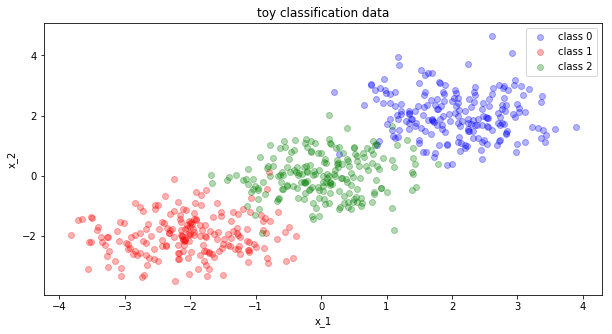

In [3]:
params_1 = {'mean': [2, 2], 'covariance_matrix': 0.5*np.eye(2)}
params_2 = {'mean': [-2, -2], 'covariance_matrix': 0.5 * np.eye(2)}
params_3 = {'mean': [0, 0], 'covariance_matrix': 0.5 * np.eye(2)}
params = [params_1, params_2,params_3]
x, y = two_clusters_gaussian(params, 200)

fig, ax = plt.subplots(1, 1, figsize=(10, 5))
ax.scatter(x[y == 0, 0], x[y == 0, 1], alpha=0.3, color='blue', label='class 0')
ax.scatter(x[y == 1, 0], x[y == 1, 1], alpha=0.3, color='red', label='class 1')
ax.scatter(x[y == 2, 0], x[y == 2, 1], alpha=0.3, color='green', label='class 2')

ax.set_xlabel('x_1')
ax.set_ylabel('x_2')
ax.set_title('toy classification data')
ax.legend(loc='best')
plt.show()

In [4]:
###relu activation
activation_fn_type = 'relu'
activation_fn = lambda x: np.maximum(np.zeros(x.shape), x)


###neural network model design choices
width = 5
hidden_layers = 1
input_dim = 2
output_dim = 1

architecture = {'width': width,
               'hidden_layers': hidden_layers,
               'input_dim': input_dim,
               'output_dim': output_dim,
               'activation_fn_type': 'relu',
               'activation_fn_params': 'rate=1',
               'activation_fn': activation_fn}

#set random state to make the experiments replicable
rand_state = 0
random = np.random.RandomState(rand_state)

#instantiate a Feedforward neural network object
nn = Feedforward(architecture, random=random)

In [5]:
###define design choices in gradient descent
params = {'step_size':1e-3, 
          'max_iteration':15000, 
          'random_restarts':1}

#fit my neural network to minimize MSE on the given data
nn.fit(x.T, y.reshape(1,-1), params)

Iteration 0 lower bound [2893.80011577]; gradient mag: 1814.5391208993842
Iteration 100 lower bound [2353.37946826]; gradient mag: 1675.7983146995505
Iteration 200 lower bound [1840.02808077]; gradient mag: 1560.7108165513034
Iteration 300 lower bound [1382.28487563]; gradient mag: 1278.268506361947
Iteration 400 lower bound [1065.31125729]; gradient mag: 854.3267689890724
Iteration 500 lower bound [844.08389293]; gradient mag: 698.1116989621638
Iteration 600 lower bound [597.32977738]; gradient mag: 733.6794904691842
Iteration 700 lower bound [270.46537706]; gradient mag: 819.8038080423911
Iteration 800 lower bound [-25.46206576]; gradient mag: 770.5795973032679
Iteration 900 lower bound [-242.8389588]; gradient mag: 686.3896578348956
Iteration 1000 lower bound [-413.4968445]; gradient mag: 643.68534591075
Iteration 1100 lower bound [-567.60979659]; gradient mag: 634.000740975861
Iteration 1200 lower bound [-720.50159575]; gradient mag: 645.1126600102712
Iteration 1300 lower bound [-8

Iteration 10800 lower bound [-6611.50293887]; gradient mag: 2.056097409323118
Iteration 10900 lower bound [-6611.60803276]; gradient mag: 1.9843038229013086
Iteration 11000 lower bound [-6611.75152922]; gradient mag: 2.1765500756194904
Iteration 11100 lower bound [-6611.83398207]; gradient mag: 1.87146997081809
Iteration 11200 lower bound [-6611.96917325]; gradient mag: 1.9309829222436885
Iteration 11300 lower bound [-6612.09848826]; gradient mag: 11.134613381896157
Iteration 11400 lower bound [-6612.25365553]; gradient mag: 1.9196917984056039
Iteration 11500 lower bound [-6612.35321432]; gradient mag: 1.791158651785305
Iteration 11600 lower bound [-6612.46718731]; gradient mag: 1.6871032118756517
Iteration 11700 lower bound [-6612.58153451]; gradient mag: 4.0147473143418875
Iteration 11800 lower bound [-6612.69043775]; gradient mag: 14.931228141906827
Iteration 11900 lower bound [-6612.72044266]; gradient mag: 13.408723817746106
Iteration 12000 lower bound [-6612.7433503]; gradient ma

In [12]:
params_hmc={
       'num_samples':10000,
       'step_size':1e-3, 
       'L':50,
       'init': nn.weights,
       'burn':.1, 
       'thin':2,
}


def log_prior(W):
    Sigma=25*np.eye(nn.D)
    D_bayes=Sigma.shape[0]
    Sigma_inv= np.linalg.inv(Sigma)
    Sigma_det = np.linalg.det(Sigma)
    constant_W = -0.5 * (D_bayes * np.log(2 * np.pi) + np.log(Sigma_det))
    exponential_W = -0.5 * np.diag(np.dot(np.dot(W, Sigma_inv), W.T))
    log_p_W = constant_W + exponential_W
    return log_p_W

def log_likelihood(W):
    D_bayes=len(y.reshape((-1,1)))
    sigma_y=0.5
    constant = (-np.log(sigma_y) - 0.5 * np.log(2 * np.pi)) * D_bayes
    exponential = -0.5 * sigma_y**-2 * np.sum((y.reshape((1, 1, D_bayes)) - nn.forward(W, x.T))**2, axis=2).flatten()
    return constant + exponential



In [13]:
q=hmc(log_prior, log_likelihood, **params_hmc)

1
100 : 0.8
200 : 0.765
300 : 0.77
400 : 0.77
500 : 0.77
600 : 0.7616666666666667
700 : 0.7757142857142857
800 : 0.77625
900 : 0.7766666666666666
1000 : 0.771
1100 : 0.7672727272727272
1200 : 0.7675
1300 : 0.7692307692307693
1400 : 0.7692857142857142
1500 : 0.7673333333333333
1600 : 0.764375
1700 : 0.7641176470588236
1800 : 0.7622222222222222
1900 : 0.7652631578947369
2000 : 0.7655
2100 : 0.7642857142857142
2200 : 0.765
2300 : 0.7665217391304348
2400 : 0.7666666666666667
2500 : 0.7664
2600 : 0.7646153846153846
2700 : 0.7633333333333333
2800 : 0.7625
2900 : 0.7627586206896552
3000 : 0.7643333333333333
3100 : 0.7629032258064516
3200 : 0.7625
3300 : 0.7615151515151515
3400 : 0.7588235294117647
3500 : 0.7608571428571429
3600 : 0.7613888888888889
3700 : 0.7637837837837838
3800 : 0.7652631578947369
3900 : 0.764102564102564
4000 : 0.76575
4100 : 0.7658536585365854
4200 : 0.7654761904761904
4300 : 0.7658139534883721
4400 : 0.7665909090909091
4500 : 0.7668888888888888
4600 : 0.7680434782608696


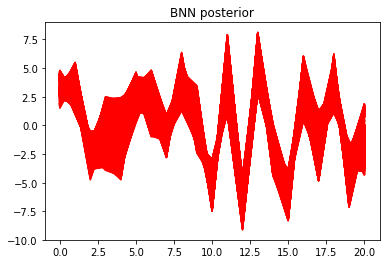

(21, 3332)
[ 2.58825224  4.30394148 -2.56316236  2.22176348  2.17679582  3.07521965
 -0.41266202 -1.33396624  3.15537318  2.42386213 -5.70777452  4.9937354
 -4.64227095  5.76806571 -4.22941838 -7.73758146  5.2390506  -3.88358579
  4.87980001 -6.45198464 -1.09719865]


In [27]:
q_=np.asarray(q).T
plt.plot(range(len(q_)),q_, color='r')
plt.title('BNN posterior')
plt.show()
print(q_.shape)
print(q[0])